In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
img_bgr = cv2.imread("C:/Users/akihiro.tanaka.CORP/Downloads/pictures/penguins1.jpg")
h, w = img_bgr.shape[:2]
scale = (640 * 480 / (w * h)) ** 0.8
img_bgr_resize = cv2.resize(img_bgr, dsize=None, fx=scale, fy=scale)
img_rgb = cv2.cvtColor(img_bgr_resize, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_bgr_resize, cv2.COLOR_BGR2GRAY)

# 11-1 テンプレートマッチングによるパターンの検出
## 11-1-1 テンプレートマッチング
---
2つの画像が同じかどうかを判断するために、画像を重ね合わせて違いを調べるような処理を一般に**マッチング**と呼ぶ。  
画像の視覚的特徴や画素値そのものをパターンと呼び、パターンの存在や位置を検出することをパターンマッチングと呼ぶ。
あらかじめ標準パターンを**テンプレート**として用意しておき、入力画像とのマッチングを行うことを**テンプレートマッチング**と呼ぶ。
テンプレート画像を画像全体に対して移動し、それぞれの位置で類似度を調べるとき、これを画像の左端から水平方向に、それを順次下の行に向かって探索することを**ラスタスキャン**と呼ぶ。

## 11-1-2 類似度
---
テンプレートマッチングでは、2つの画像間の**類似度**または**相違度**を調べるために、SSDやSADを利用することが多い。
$$
    R_{SSD}=\sum_{j=0}^{N-1}\sum_{i=0}^{M-1}(I(i,j)-T(i,j))^2\\
    R_{SAD}=\sum_{j=0}^{N-1}\sum_{i=0}^{M-1}|I(i,j)-T(i,j)|
$$
これらは、一致したときに0となるので、相違度を表している。  
類似度として、以下のNCCを利用することもある。
$$
    R_{NCC}=\frac{\sum_{j=0}^{N-1}\sum_{i=0}^{M-1}I(i,j)T(i,j)}
                 {\sqrt{\sum_{j=0}^{N-1}\sum_{i=0}^{M-1}I(i,j)^2×\sum_{j=0}^{N-1}\sum_{i=0}^{M-1}T(i,j)^2}}
$$
テンプレートと対象画像のベクトルを$\boldsymbol{T}$と$\boldsymbol{I}$と考えると、  
SADは先端間の市街地距離、SSDはユークリッド距離の2乗、NCCはベクトルのなす角を表している。  
また、以下の相互相関係数を類似度として利用することもある。
$$
    R_{ZNCC}=\frac{\sum_{j=0}^{N-1}\sum_{i=0}^{M-1}(I(i,j)-\bar{I})(T(i,j)-\bar{T})}
                  {\sqrt{\sum_{j=0}^{N-1}\sum_{i=0}^{M-1}(I(i,j)-\bar{I})^2×\sum_{j=0}^{N-1}\sum_{i=0}^{M-1}(T(i,j)-\bar{T})^2}}
$$
ここで、$\bar{I}$と$\bar{T}$は領域内の画素値の平均値である。
$$
    \bar{I}=\sum_{j=0}^{N-1}\sum_{i=0}^{M-1}I(i,j),\bar{T}=\sum_{j=0}^{N-1}\sum_{i=0}^{M-1}T(i,j)
$$

## 11-1-3 サブピクセル位置推定
---
類似度や相違度の最大値または最小値を与える位置から、画素単位でテンプレートの位置が得られる。  
さらに精密に求めるためにフィッティング関数で補間し、サブピクセルの位置を求める手法が**サブピクセル位置推定（類似度補間手法）**である。  
相違度が最小の位置における相違度の値を$R(0)$、その隣接位置での値を$R(-1),R(1)$とする。  
等角直線補正
$$
    \hat{d}=
    \begin{cases}
        \frac{1}{2} \frac{R(1)-R(-1)}{R(0)-R(-1)} & (R(1)<R(-1)) \\
        \frac{1}{2} \frac{R(1)-R(-1)}{R(0)-R(1)} & (それ以外)
    \end{cases}
$$
パラボラフィッティング
$$
    \hat{d}=\frac{R(-1)-R(1)}{2R(-1)-4R(0)+2R(1)}
$$

## 11-1-4 高速探索法
---
### 残差逐次検定法
SADを計算するとき、領域内の差の絶対値を加算している。  
加算の途中で残差があるしきい値を超えたら、検出位置ではないと判断し、加算を打ち切りつぎの位置での計算に移る方法を**残差逐次検定法**である。  
### 疎密探索法
画像情報を何段階かの解像度で表現し、効率的に探索する方法を**粗密探索法**と呼ぶ。  
イメージピラミッドを構成し、低解像度画像から順に探索を行う。

## 11-1-5 参照画像の選択による高速化
---
テンプレートに含まれるがそから同時生起行列を用いて選択された独自性の高い画素を用いて類似度計算することで、高速にマッチングを行う。  
同時生起行列の確立を計算し、確率が小さいパターンほど独自性が高いと言える。

### OpenCVによるテンプレートマッチングの例

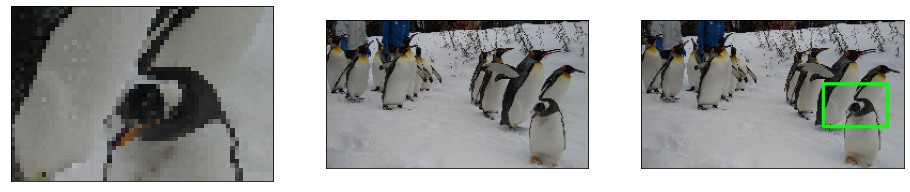

In [3]:
templ = img_rgb[60:100,170:230,:]
test = img_rgb.copy()

result = cv2.matchTemplate(test, templ, cv2.TM_CCOEFF_NORMED)
mmr = cv2.minMaxLoc(result)
pos = mmr[3]

dst = test.copy()
cv2.rectangle(dst, pos, (pos[0] + templ.shape[1], pos[1] + templ.shape[0]), (0, 255, 0), 2)

fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].imshow(templ)
ax[0].set_xticks([]);
ax[0].set_yticks([]);

ax[1].imshow(img_rgb);
ax[1].set_xticks([]);
ax[1].set_yticks([]);

ax[2].imshow(dst);
ax[2].set_xticks([]);
ax[2].set_yticks([]);

# 11-2 エッジ情報とヒストグラムによるパターン検出
## 11-2-1 エッジ情報を用いたチャンファーマッチング
---
エッジ相違度を用いて行うテンプレートマッチングを**チャンファーマッチング**と呼ぶ。  
まず、エッジ画像を作成し、距離変換処理を行い距離変換画像を作成する。  
入力画像から作成した距離変換画像とテンプレート画像から作成したエッジ画像を、相違度に基づいてマッチングを行う。

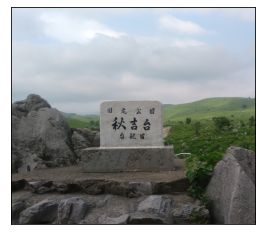

In [4]:
img_bgr = cv2.imread("C:/Users/akihiro.tanaka.CORP/Downloads/pictures/akiyoshi.jpg")
h, w = img_bgr.shape[:2]
scale = (640 * 480 / (w * h)) ** 0.3
img_bgr_resize = cv2.resize(img_bgr, dsize=None, fx=scale, fy=scale)
img_bgr_resize = img_bgr_resize[0:800,100:1000,:]
img_rgb = cv2.cvtColor(img_bgr_resize, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_bgr_resize, cv2.COLOR_BGR2GRAY)
plt.imshow(img_rgb, 'gray');
plt.xticks([]);
plt.yticks([]);

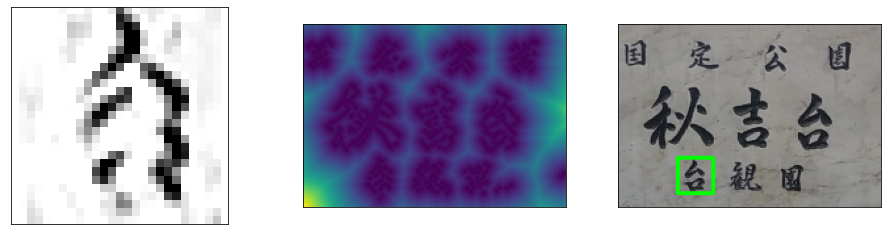

In [5]:
thresh = img_gray[360:500,350:550]
templ = thresh[103:130,45:72]

ret, thresh = cv2.threshold(img_gray[360:500,350:550], 100, 255, cv2.THRESH_BINARY)
test = thresh.copy()

templ = cv2.bitwise_not(cv2.Sobel(templ, -1, 1, 0, ksize=3)).astype('float32')
test = cv2.bitwise_not(cv2.Sobel(test, -1, 1, 1, ksize=3))
dist_test = cv2.distanceTransform(test,cv2.DIST_L2,3)

result = cv2.matchTemplate(dist_test, templ, cv2.TM_CCOEFF_NORMED)
mmr = cv2.minMaxLoc(result)
pos = mmr[3]

dst = img_rgb[360:500,350:550].copy()
cv2.rectangle(dst, pos, (pos[0] + templ.shape[1], pos[1] + templ.shape[0]), (0, 255, 0), 2)

fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].imshow(templ, 'gray')
ax[0].set_xticks([]);
ax[0].set_yticks([]);

ax[1].imshow(dist_test);
ax[1].set_xticks([]);
ax[1].set_yticks([]);

ax[2].imshow(dst);
ax[2].set_xticks([]);
ax[2].set_yticks([]);

## 11-2-2 ヒストグラム情報を用いたアクティブ探索
---
### カラーヒストグラムの類似度
**カラーヒストグラム**は、カラー空間を量子化した際の各色番号に対する頻度を表したものである。  
**ヒストグラムインタセクション** は、以下のようにカラーヒストグラムの各色番号における頻度の大小を比べ、小さいほうの頻度の和である。
$$
    \rho(p,q)=\sum_{i=1}^{n}min(p_{i},q_{i})
$$
**バタチャリア係数**では、各色番号における頻度を掛け合わせて、その総和を求める。
$$
    \rho(p,q)=\sum_{i=1}^{n}\sqrt{p_{i}q_{i}}
$$
以下に例を示す。
ヒストグラムインタセクション（交差）、バタチャリア係数の他にカイ2乗と相関による類似度の計算結果も示す。

In [6]:
img_bgr1 = cv2.imread("C:/Users/akihiro.tanaka.CORP/Downloads/pictures/penguins1.jpg")
h, w = img_bgr1.shape[:2]
scale = (640 * 480 / (w * h)) ** 0.8
img_bgr_resize1 = cv2.resize(img_bgr1, dsize=None, fx=scale, fy=scale)
img_rgb1 = cv2.cvtColor(img_bgr_resize1, cv2.COLOR_BGR2RGB)
img_gray1 = cv2.cvtColor(img_bgr_resize1, cv2.COLOR_BGR2GRAY)

img_bgr2 = cv2.imread("C:/Users/akihiro.tanaka.CORP/Downloads/pictures/penguins2.jpg")
h, w = img_bgr2.shape[:2]
scale = (640 * 480 / (w * h)) ** 0.8
img_bgr_resize2 = cv2.resize(img_bgr2, dsize=None, fx=scale, fy=scale)
img_rgb2 = cv2.cvtColor(img_bgr_resize2, cv2.COLOR_BGR2RGB)
img_gray2 = cv2.cvtColor(img_bgr_resize2, cv2.COLOR_BGR2GRAY)

In [7]:
def make_post_lut(n):
    """
    ポスタリゼーション用のLUTを作成
    """
    x = np.arange(256)
    y = np.floor(x/n)*int(255/np.floor(255/n))
    y = y.astype('uint8')
    return y

y=make_post_lut(16)

for i in range(3):
    img_rgb1[:,:,i] = img_lut = cv2.LUT(img_rgb1[:,:,i], y)
    img_rgb2[:,:,i] = img_lut = cv2.LUT(img_rgb2[:,:,i], y)

In [8]:
def make_color_number(img):
    return img[:,:,0]*256**2+img[:,:,1]*256+img[:,:,2]

img1 = make_color_number(img_rgb1).reshape(img_rgb1.shape[0],img_rgb1.shape[1],1)
img2 = make_color_number(img_rgb2).reshape(img_rgb1.shape[0],img_rgb1.shape[1],1)

n_bins = 256**3  # ビンの数
hist_range = [0, 256**3]  # 集計範囲

hist1 = cv2.calcHist([img1.astype('uint8')], channels=[0], mask=None, histSize=[n_bins], ranges=hist_range)
hist_norm1 = hist1 / hist1.sum()
hist_norm1 = hist_norm1.squeeze(axis=-1)
hist1 = hist1.squeeze(axis=-1)

hist2 = cv2.calcHist([img2.astype('uint8')], channels=[0], mask=None, histSize=[n_bins], ranges=hist_range)
hist_norm2 = hist2 / hist2.sum()
hist_norm2 = hist_norm2.squeeze(axis=-1)
hist2 = hist2.squeeze(axis=-1)

In [9]:
print('相関: ',cv2.compareHist(hist_norm1, hist_norm2, method=cv2.HISTCMP_CORREL))
print('カイ2乗: ',cv2.compareHist(hist_norm1, hist_norm2, method=cv2.HISTCMP_CHISQR))
print('交差(ヒストグラムインタセクション): ',cv2.compareHist(hist_norm1, hist_norm2, method=cv2.HISTCMP_INTERSECT))
print('Bhattacharyya距離: ',cv2.compareHist(hist1, hist2, method=cv2.HISTCMP_BHATTACHARYYA))

相関:  0.9954045150958509
カイ2乗:  0.016083827119052596
交差(ヒストグラムインタセクション):  0.9398140158737078
Bhattacharyya距離:  0.044777924947912454


# 11-3 特徴点検出
画像間の対応位置を求めるときに、画像中の特徴点をまず検出して、その特徴点の対応を探索することがある。
コーナーや特徴点、輪郭線を検出する方法を説明する。

## 11-3-1 コーナー検出
---
### ハリスのコーナー検出
画像からコーナーを検出する代表的な手法である**ハリスのコーナー検出**の手順を示す。
1. 入力画像$I$に対し、ガウス関数$G(\sigma)$をx,yの各方向で微分した$G_{x}(\sigma),G_{y}(\sigma)$を畳み込み、勾配画像を求める。  
$I_{x}=G_{x}(\sigma)*I, \quad I_{y}=G_{y}(\sigma)*I$
2. 各勾配画像の積により、各方向における勾配の大きさを算出する。  
$I_{xx}=I_{x}・I_{x},\quad I_{yy}=I_{y}・I_{y},\quad I_{xy}=I_{x}・I_{y}$
3. $I_{xx},I_{yy},I_{xy}$の局所領域における勾配の総和$S_{xx},S_{yy},S_{xy}$を求める。  
以下に示すようなガウス関数$G(\sigma')$による重み付き和を用いることが多い。  
$S_{xx}=G(\sigma')*I_{xx},\quad S_{yy}=G(\sigma')*I_{yy},\quad S_{xy}=G(\sigma')*I_{xy}$
4. 以下の行列$M(x,y)$を定義する。
$$
    M(x,y)=
    \left[\begin{array}{cc}
    S_{xx}(x,y)&S_{xy}(x,y)\\
    S_{xy}(x,y)&S_{yy}(x,y)
    \end{array}\right]
$$
5. 画素(x,y)がコーナーである場合、行列$M(x,y)$の固有値$\lambda_{1},\lambda_{2}$はともに大きい値となる。  
そこで、コーナー関数$R$を以下のように定義する。$k$は調整パラメータである。
$$
    R = detM - k (trM)^2\\
    detM = \lambda_{1}\lambda_{2},\quad trM = \lambda_{1}+\lambda_{2}
$$
6. Rの値が局所的な最大値となる画素をコーナーとして検出する。  
適当なしきい値を設け、有効なコーナーだけを選択する。

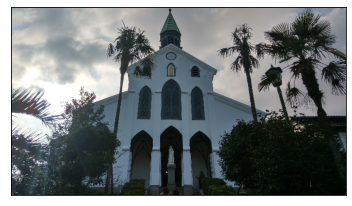

In [10]:
img_bgr = cv2.imread("C:/Users/akihiro.tanaka.CORP/Downloads/pictures/yushima.jpg")
h, w = img_bgr.shape[:2]
scale = (640 * 480 / (w * h)) ** 0.5
img_bgr_resize = cv2.resize(img_bgr, dsize=None, fx=scale, fy=scale)
img_rgb = cv2.cvtColor(img_bgr_resize, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_bgr_resize, cv2.COLOR_BGR2GRAY)
plt.imshow(img_rgb, 'gray');
plt.xticks([]);
plt.yticks([]);

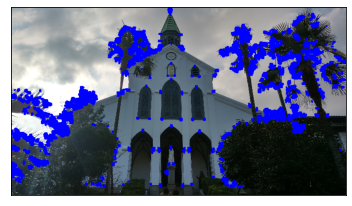

In [11]:
color = img_rgb.copy()
gray = np.float32(img_gray)
dst = cv2.cornerHarris(gray, 7, 11, 0.05)

#result is dilated for marking the corners, not important
dst = cv2.dilate(dst, None)

# Threshold for an optimal value, it may vary depending on the image.
color[dst>0.01*dst.max()]=[0,0,255]
plt.imshow(color);
plt.xticks([]);
plt.yticks([]);

### FASTによるコーナー検出
**FAST(Feature from Accelerated Segment Test)**のコーナー検出は、決定木をトラバーサルしてたどり着いた末端ノードが保持する情報により、コーナーを検出する方法である。  
まず、注目画素$p(x,y)$を中心とする周囲16画素を考える。  
周囲16画素の画素値が注目画素の画素値よりも明るい場合はBrighter、暗い場合はDarker、類似している場合はSimilarと3値化する。  
BrighterまたはDarkerが一定数以上連続する場合に、注目画素をコーナーとする。  
FASTでは決定木を用いた判定を行う。

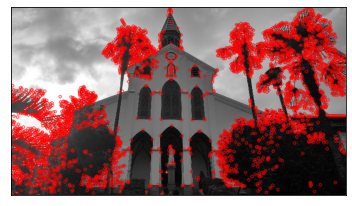

In [12]:
color = img_rgb.copy()
gray = np.float32(img_gray)

fast = cv2.FastFeatureDetector_create(threshold=40)

# キーポイントを求めて描画する
kp = fast.detect(img_gray, None)
img2 = cv2.drawKeypoints(img_gray, kp, None, color=(255,0,0))

plt.imshow(img2);
plt.xticks([]);
plt.yticks([]);

### Shi-Tomasiのコーナー検出
ハリスのコーナー検出を改善したもの。物体追跡に有用である。

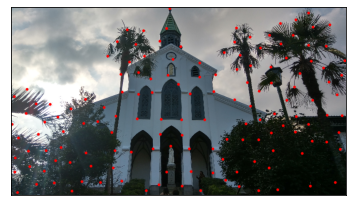

In [13]:
color = img_rgb.copy()
gray = np.float32(img_gray)

corners = cv2.goodFeaturesToTrack(gray,250,0.01,30)
corners = np.int0(corners)

for i in corners:
    x,y = i.ravel()
    cv2.circle(color,(x,y),3,255,-1)

plt.imshow(color);
plt.xticks([]);
plt.yticks([]);

## 11-3-2 DoG画像を用いた特徴点とスケールの検出
---
画像中に拡大縮小があると、画像間の特徴点領域の濃淡パターンが変化するため、特徴点の対応付けができない。  
特徴点とその領域の大きさを表すスケールを検出する必要があり、複数のDoG画像で計算することができる。  
DoGはスケールの異なるガウス関数$G(\sigma)$と入力画像$I$を畳み込んだ平滑化画像$L$の差分により求める。
$$
    D(\sigma)=(G(k\sigma)-G(\sigma))*I=L(k\sigma)-L(\sigma)
$$
$k$は$\sigma$の増加率であり、スケールを少しずつ大きくして複数のDoG画像を求める。

In [14]:
def DoG(img, kernel, sigma, k1, k2):
    img = img.astype('float32')
    tmp1 = cv2.GaussianBlur(img, (kernel, kernel) , sigma*k1, sigma*k1)
    tmp2 = cv2.GaussianBlur(img, (kernel, kernel) , sigma*k2, sigma*k2)
    dst = tmp1 - tmp2
    return dst

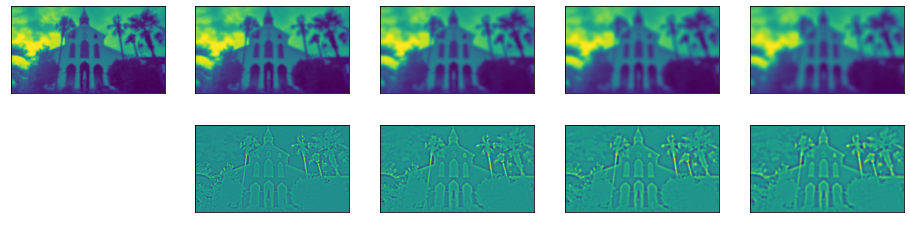

In [15]:
fig, ax = plt.subplots(2, 5, figsize=(16, 4))
for i in range(5):
    k=1.4**i
    tmp = cv2.GaussianBlur(img_gray, (31, 31) , 3*k, 3*k)
    ax[0][i].imshow(tmp)
    ax[0][i].set_xticks([]);
    ax[0][i].set_yticks([]);

im1 = DoG(img_gray, 31, 3, 1.2,1)
im2 = DoG(img_gray, 31, 3, 1.2**2,1.2)
im3 = DoG(img_gray, 31, 3, 1.2**3,1.2**2)
im4 = DoG(img_gray, 31, 3, 1.2**4,1.2**3)

ax[1][0].axis('off')
ax[1][1].imshow(im1)
ax[1][1].set_xticks([]);
ax[1][1].set_yticks([]);
ax[1][2].imshow(im2)
ax[1][2].set_xticks([]);
ax[1][2].set_yticks([]);
ax[1][3].imshow(im3)
ax[1][3].set_xticks([]);
ax[1][3].set_yticks([]);
ax[1][4].imshow(im4)
ax[1][4].set_xticks([]);
ax[1][4].set_yticks([]);

# 11-4 特徴点の記述とマッチング
## 11-4-1 スケールと回転に不変な特徴記述(SIFT)
---
**SIFT**の特徴記述は、検出したスケールい合わせた領域に対して、回転に不変な特徴量を記述するためにオリエンテーションを算出する。  
オリエンテーションは特徴点における方向を表す。  
特徴点のスケールに合わせた局所領域内の平滑化画像$L(x,y)$から勾配強度$m(x,y)$と勾配方向$\theta(x,y)$を求める。
$$
    m(x,y)=\sqrt{f_{x}(x,y)^2+f_{y}(x,y)^2}\\
    \theta(x,y)=\tan^{-1}\frac{f_{y}(x,y)}{f_{x}(x,y)}\\
    f_{x}(x,y)=L(x+1,y)-L(x-1,y)\\
    f_{y}(x,y)=L(x,y+1)-L(x,y-1)
$$
勾配強度と勾配方向から、重み付き勾配方向ヒストグラムを作成する。勾配方向は36方向に量子化し、中心に近いほど高く重み付けして投票する。  
オリエンテーション方向に特徴記述する矩形領域を回転し、勾配情報に基づく特徴量を記述する。  
オリエンテーション方向に座標軸を合わせた領域で特徴量を記述するため、回転に不変な特徴量とある。

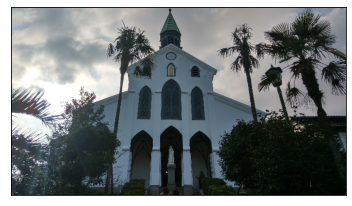

In [16]:
img_bgr = cv2.imread("C:/Users/akihiro.tanaka.CORP/Downloads/pictures/yushima.jpg")
h, w = img_bgr.shape[:2]
scale = (640 * 480 / (w * h)) ** 0.5
img_bgr_resize = cv2.resize(img_bgr, dsize=None, fx=scale, fy=scale)
img_rgb = cv2.cvtColor(img_bgr_resize, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_bgr_resize, cv2.COLOR_BGR2GRAY)
plt.imshow(img_rgb, 'gray');
plt.xticks([]);
plt.yticks([]);

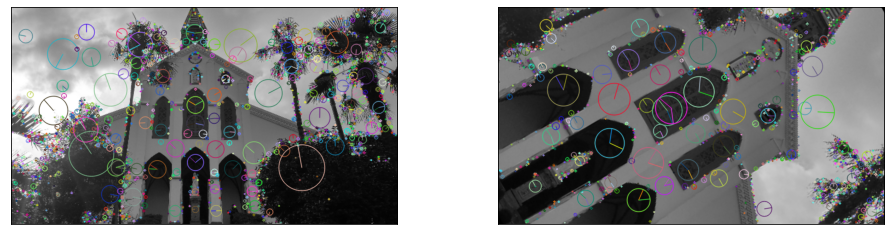

In [17]:
h, w = img_rgb.shape[:2]
affine_trans1 = cv2.getRotationMatrix2D((w//2,h//2), -0.0, 1.1)
affine_trans2 = cv2.getRotationMatrix2D((w//2,h//2), -60.0, 2)


fig, ax = plt.subplots(1, 2, figsize=(16, 4))
for i in range(1,3):
    dst = cv2.warpAffine(img_rgb, globals()['affine_trans'+str(i)], (w, h))
    gray= cv2.cvtColor(dst,cv2.COLOR_BGR2GRAY)

    detector = cv2.xfeatures2d.SIFT_create()
    kp = detector.detect(gray, None)

    img=cv2.drawKeypoints(gray,kp,gray,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    ax[i-1].imshow(img);
    ax[i-1].set_xticks([]);
    ax[i-1].set_yticks([]);

### SURF
**SURF**は，SIFTの高速化版であり、SIFTはLoGをDoGを用いて近似していたところを、**ボックスフィルタ**を使ってこの近似を行ったものである。

In [18]:
"""
surf =cv2.xfeatures2d.SURF_create()
kp, des = surf.detectAndCompute(img,None)
img2 = cv2.drawKeypoints(img_gray,kp,None,(255,0,0),4)

plt.imshow(img2),plt.show()
"""

'\nsurf =cv2.xfeatures2d.SURF_create()\nkp, des = surf.detectAndCompute(img,None)\nimg2 = cv2.drawKeypoints(img_gray,kp,None,(255,0,0),4)\n\nplt.imshow(img2),plt.show()\n'

### KAZE特徴量・AKAZE特徴量
非線形拡散フィルタを用いて算出する特徴量  
AKAZEはKAZEを高速化したもの。

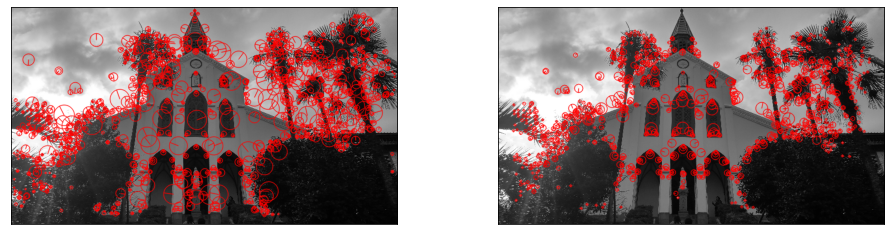

In [19]:
kaze =cv2.KAZE_create()
kp, des = kaze.detectAndCompute(img_gray,None)
img1 = cv2.drawKeypoints(img_gray,kp,None,(255,0,0),4)

akaze =cv2.AKAZE_create()
kp, des = akaze.detectAndCompute(img_gray,None)
img2 = cv2.drawKeypoints(img_gray,kp,None,(255,0,0),4)

fig, ax = plt.subplots(1, 2, figsize=(16, 4))
ax[0].imshow(img1);
ax[0].set_xticks([]);
ax[0].set_yticks([]);

ax[1].imshow(img2);
ax[1].set_xticks([]);
ax[1].set_yticks([]);

## 11-4-2 2値特徴量
---
SIFT特徴量は計算に時間を要するというデメリットがある。
そこで特徴量を2値ベクトルで表現する手法が提案されている。
**BRIEF**は、ランダムに選択された2点の画素値の差の符号かｒ2値特徴量を生成する。  
**ORB**は、BRIEFの処理におけるサンプリングペアを教師なし学習で決定する。  
**BRISK**は、BRIEFを発展させた方法で、スケール不変性と回転不変性を得ている。

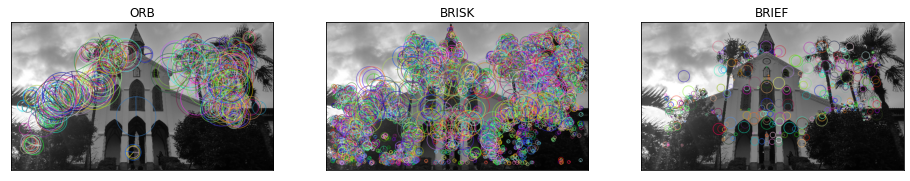

In [20]:
method =[cv2.ORB_create(), cv2.BRISK_create()]
method_names = ['ORB', 'BRISK']

fig, ax = plt.subplots(1, 3, figsize=(16, 4))
for i in range(len(method)):
    gray= cv2.cvtColor(img_rgb,cv2.COLOR_BGR2GRAY)
    
    detector = method[i]
    kp = detector.detect(gray, None)
    
    img=cv2.drawKeypoints(gray, kp, gray, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    ax[i].imshow(img);
    ax[i].set_xticks([]);
    ax[i].set_yticks([]);

    ax[i].set_title(method_names[i]);

gray= cv2.cvtColor(img_rgb,cv2.COLOR_BGR2GRAY)

star = cv2.xfeatures2d.StarDetector_create()
brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()
kp = star.detect(img_rgb,None)

kp, des = brief.compute(img_rgb, kp)
img=cv2.drawKeypoints(gray, kp, gray, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

ax[2].imshow(img);
ax[2].set_xticks([]);
ax[2].set_yticks([]);
ax[2].set_title('BRIEF');

### その他の特徴量
**ブロブ**を検出する特徴量

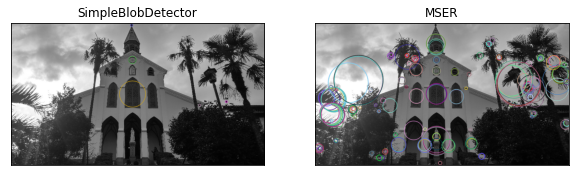

In [21]:
method =[cv2.SimpleBlobDetector_create(), cv2.MSER_create()]
method_names = ['SimpleBlobDetector', 'MSER']

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
for i in range(len(method)):
    gray= cv2.cvtColor(img_rgb,cv2.COLOR_BGR2GRAY)
    
    detector = method[i]
    kp = detector.detect(gray, None)
    
    img=cv2.drawKeypoints(gray, kp, gray, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    ax[i].imshow(img);
    ax[i].set_xticks([]);
    ax[i].set_yticks([]);

    ax[i].set_title(method_names[i]);

## 11-4-3 対応点マッチング
---
異なる画像間で検出された各特徴点の特徴量を比較することで、画像間の対応付けが可能となる。  
画像$I_{1}$の特徴量を$x$、画像$I_{2}$の特徴量を$y$としたとき、2つの特徴量の類似度は、ユークリッド距離の2乗distにより算出できる。
$$
    dist(x,y)=\sum_{i=1}^{128}(x_{i}-y_{i})^2
$$
画像$I_{1}$のある1つの特徴点と画像$I_{2}$の全特徴点との距離を算出し、最も小さいもの、2番目に小さいものを
$dist_{1}(x,y)$、$dist_{2}(x,y)$とする。  
比率テストを行い、信頼の高い特徴点と対応点を判定する。
$$
    \frac{dist_{1}(x,y)}{dist_{2}(x,y)}\leq k
$$
$k$を小さくすると対応点が減少する。

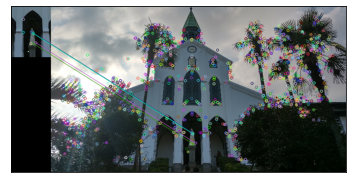

In [22]:
img = img_rgb.copy()

templ = img[250:380, 300:400]


detector = cv2.AKAZE_create()
keypoints1, descriptor1 = detector.detectAndCompute(templ, None)
keypoints2, descriptor2 = detector.detectAndCompute(img, None)

matcher = cv2.BFMatcher()

matches = matcher.knnMatch(descriptor1, descriptor2, k=2)

# マッチング精度が高いもののみ抽出
ratio = 0.8
good = []
for m, n in matches:
    if m.distance < ratio * n.distance:
        good.append([m])

dst = cv2.drawMatchesKnn(templ, keypoints1, img, keypoints2, good, None, flags=0)
plt.imshow(dst, cmap="gray");
plt.xticks([]);
plt.yticks([]);

# 11-5 図形要素検出
## 11-5-1 ハフ変換
---
xy画像空間中の直線は、$\hat{a}$を傾き、$\hat{b}$を切片としたとき、以下のように表される。
$$y=\hat{a}x+\hat{b}$$
abパラメータ空間では、xy画像空間中の直線を1点で表すことができる。  
xy画像空間中の直線$l$上の点$(x_{i},y_{i})$は、以下によってabパラメータ空間に写像される。  
$$b=-x_{i}a+y_{i}$$
abパラメータ空間では、xy画像空間中の点を傾き$-x_{i}$、切片${y_{i}}$で表すことができる。 
複数の点をabパラメータ空間に写像すると、点の数だけ直線が描画され、これらの直線は1点$(\hat{a},\hat{b})$で交差する。  
このように直線検出原理を**ハフ変換**と呼ぶ。  
ハフ変換の処理は以下のように行われる。  
1. エッジ検出処理などで、出力画像を用意。2値化処理で、線の上に位置する可能性がある画素を用意する。  
2. abパラメータ空間を小さなセルに分割し、線候補画素をabパラメータ空間に写像したときに生成される直線が通過するセルの値を1増やす。  
この処理は**投票**と呼ばれる。  
3. この処理をすべての線候補画素について行う。結果、abパラメータ空間は直線の通過した回数を値として持つ（投票度数）。  
4. abパラメータ空間で。投票度数が大きなセルを探索すると、その座標がxy画像空間中の直線の傾きと切片に相当する。  
また、xy画像空間中の直線を以下のように表し、パラメータ空間の大きさを制限することができる。  
$$\hat{\rho}=x\cos{\hat{\theta}}+y\sin{\hat{\theta}}$$
ただし、$\hat{\rho}$は原点から直線までの符号付距離、\hat{\theta}は原点から直線への垂角である。  
一方、xy画像空間中の直線$l$上の点$(x_{i},y_{i})$は、$\rho\theta$空間では正弦波に写像される。  
$$\rho=x_{i}\cos{\theta}+y_{i}\cos{\theta}=A\sin_{\theta+\alpha}$$
ただし、$A=\sqrt{x_{i}^2+y_{i}^2}$、$\alpha=\cos-{-1}(y_{i}/A)$である。

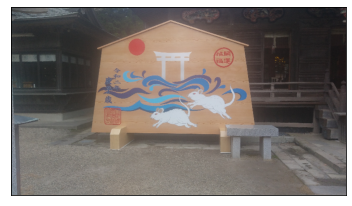

In [23]:
img_bgr = cv2.imread("C:/Users/akihiro.tanaka.CORP/Downloads/pictures/oarai.jpg")
h, w = img_bgr.shape[:2]
scale = (640 * 480 / (w * h)) ** 0.5
img_bgr_resize = cv2.resize(img_bgr, dsize=None, fx=scale, fy=scale)
img_rgb = cv2.cvtColor(img_bgr_resize, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_bgr_resize, cv2.COLOR_BGR2GRAY)
plt.imshow(img_rgb, 'gray');
plt.xticks([]);
plt.yticks([]);

### 直線検出例
まずは、標準ハフ変換による検出例を示す。

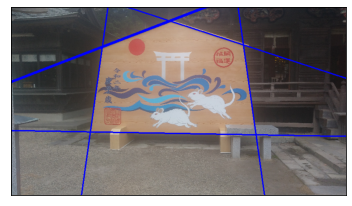

In [24]:
img = img_rgb.copy()
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,200,150,apertureSize = 3)

lines = cv2.HoughLines(edges,1,np.pi/180,100)

for rho,theta in lines[:,0,:]:
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 1000*(-b))
    y1 = int(y0 + 1000*(a))
    x2 = int(x0 - 1000*(-b))
    y2 = int(y0 - 1000*(a))

    cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)

plt.imshow(img);
plt.xticks([]);
plt.yticks([]);

確率的ハフ変換による直線検出例を示す。

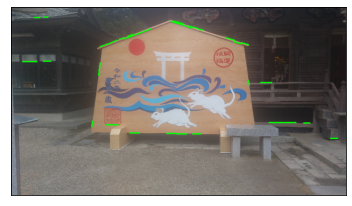

In [25]:
img = img_rgb.copy()
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,250,150,apertureSize = 3)

minLineLength = 100
maxLineGap = 10
lines = cv2.HoughLinesP(edges,1,np.pi/180,50,minLineLength,maxLineGap)
for x1,y1,x2,y2 in lines[:,0,:]:
    cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)
    
plt.imshow(img);
plt.xticks([]);
plt.yticks([]);

### 円検出例

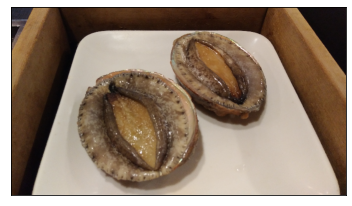

In [28]:
img_bgr = cv2.imread("C:/Users/akihiro.tanaka.CORP/Downloads/pictures/awabi.jpg")
h, w = img_bgr.shape[:2]
scale = (640 * 480 / (w * h)) ** 0.5
img_bgr_resize = cv2.resize(img_bgr, dsize=None, fx=scale, fy=scale)
img_rgb = cv2.cvtColor(img_bgr_resize, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_bgr_resize, cv2.COLOR_BGR2GRAY)
plt.imshow(img_rgb, 'gray');
plt.xticks([]);
plt.yticks([]);

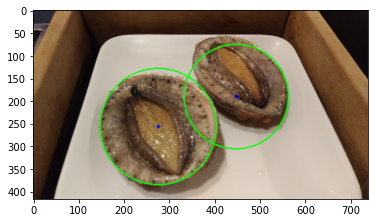

In [30]:
img = img_gray.copy()
img = cv2.medianBlur(img,19)
cimg = img_rgb.copy()

circles = cv2.HoughCircles(img,cv2.HOUGH_GRADIENT,1,60,
                            param1=80,param2=50,minRadius=0,maxRadius=0)

circles = np.uint16(np.around(circles))

for i in circles[0,:]:
    # draw the outer circle
    cv2.circle(cimg,(i[0],i[1]),i[2],(0,255,0),2)
    # draw the center of the circle
    cv2.circle(cimg,(i[0],i[1]),2,(0,0,255),3)
    
plt.imshow(cimg)

# 11-6 顕著性マップ
## 11-6-1 特徴統合理論
---
**特徴統合理論**とは、形状、色、明るさなどの情報に分解し、注目した領域に対して組み合わせることで  
物体を認識するというもの。

## 11-6-2 顕著性マップ
---
**顕著性マップ**とは、特徴統合理論に基づき、各特徴マップ生成時にそれぞれの特徴マップが独立に注意を引き付ける性質を持っていると考え、この性質を数値化したものである。
イッチらの計算モデルでは、画素値、色空間、勾配方向の3つの特徴マップを生成し、それぞれのマップから注目度を計算する。
顕著性マップを利用することで画像中の重要な物体を捉えることができるため、シームカービングや人の注視点推定などに用いられる。

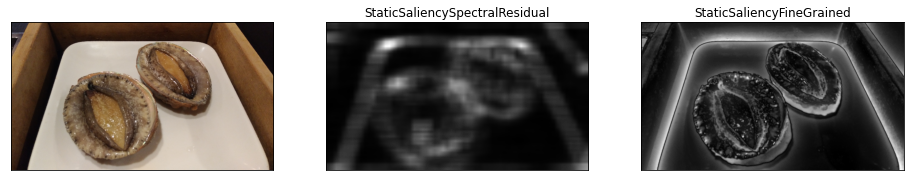

In [31]:
img = img_rgb.copy()
method = [cv2.saliency.StaticSaliencySpectralResidual_create(),
          cv2.saliency.StaticSaliencyFineGrained_create()]

method_name = ['StaticSaliencySpectralResidual',
               'StaticSaliencyFineGrained']

fig, ax = plt.subplots(1, 3, figsize=(16, 5))
ax[0].imshow(img_rgb)
ax[0].set_xticks([])
ax[0].set_yticks([])

for i in range(2):
    saliency = method[i]

    (success, saliencyMap) = saliency.computeSaliency(img)
    saliencyMap = (saliencyMap * 255).astype("uint8")

    ax[i+1].imshow(saliencyMap, 'gray')
    ax[i+1].set_xticks([])
    ax[i+1].set_yticks([])
    ax[i+1].set_title(method_name[i])